In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# read all the words
words = open('names.txt', 'r').read().splitlines()

In [3]:
len(words)

32033

In [4]:
# build vocabulary of characters and mapping to/from integers 
chars = sorted(list(set("".join(words))))
stoi = {ch:i+1 for i, ch in enumerate(chars)}
stoi["."] = 0
itos = {i:ch for ch, i in stoi.items()}
print(stoi, itos)

{'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '.': 0} {1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [ ]:
# build the dataset

block_size = 3 # context length: how many characters do we take to predict the next one?
X, Y = [],[]

for word in words:

    # print(word)
    context = [0] * block_size
    for ch in word + ".":
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        # print("".join(itos[i] for i in context), "--->", itos[ix])
        context = context[1:] + [ix]
        
X = torch.tensor(X)
Y = torch.tensor(Y)



In [ ]:
X.shape, Y.shape, X.dtype, Y.dtype

In [ ]:
X[13,2]

In [ ]:
# build the dataset
C = torch.randn((27, 2))

In [ ]:
C[X][0].shape # Every value in 32 X 3 we retrieve the coreesponding row in C. 

In [ ]:
C[X][13,2]

In [ ]:
X[13,2]

# Basically pytorch indexing is awesome.

In [ ]:
# To create embedding layer we need to create a matrix of size (27, 2) and then we can use the embedding layer to get the corresponding row for each value in X.
# We can use the embedding layer to get the corresponding row for each value in X.
# Simply done like this
emd = C[X]
emd.shape # 32 X 3 X 2

In [ ]:
W1 = torch.randn((6, 100))
b1 = torch.randn(100)

In [ ]:
h = torch.tanh(emd.view(32, 6) @ W1 + b1)

In [ ]:
# cchecking broadcast for addition
# 32   100
#  1   100

# same bias vector is added.

In [ ]:
W2 = torch.rand((100, 27))
b2 = torch.rand(27)

In [ ]:
logits = h @ W2 + b2
counts = logits.exp()
prob = counts / counts.sum(1, keepdim=True)
prob[0].sum()

In [ ]:
torch.arange(32)

In [ ]:
loss = -prob[torch.arange(32), Y].log().mean()
loss

## Grouping all Together

In [24]:
# build the dataset
def build_dataset(words):
    block_size = 3 # context length: how many characters do we take to predict the next one?
    X, Y = [],[]

    for word in words:

        # print(word)
        context = [0] * block_size
        for ch in word + ".":
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            # print("".join(itos[i] for i in context), "--->", itos[ix])
            context = context[1:] + [ix]
            
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[n1:])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])



torch.Size([45566, 3]) torch.Size([45566])
torch.Size([22767, 3]) torch.Size([22767])
torch.Size([22799, 3]) torch.Size([22799])


In [25]:
Xtr.shape, Ytr.shape

(torch.Size([45566, 3]), torch.Size([45566]))

In [26]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((30, 200), generator=g)
W2 = torch.randn((200, 27), generator=g)
b1 = torch.randn(200, generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, W2, b1, b2]

In [27]:
sum(p.nelement() for p in parameters)

11897

In [ ]:
emb = C[X]
h = torch.tanh(emb.view((-1, 30)) @ W1 + b1 ) # 32 100
logits = h @ W2 + b2
# counts = logits.exp()
# prob = counts / counts.sum(1, keepdim=True)
# loss = -prob[torch.arange(32), Y].log().mean()   #  This is classification which is what happens in Cross Entropy
loss = F.cross_entropy(logits, Y) # Cross Entropy is 3 benifits calculates forward and backward easily numerically well behaved
loss


In [28]:
for p in parameters:
    p.requires_grad=True

In [ ]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [29]:
lri = []
lossi = []
stepi = []

for i in range(200000):

    # Mini batches
    ix = torch.randint(0, Xtr.shape[0], (32,))

    #  forward pass
    emb = C[Xtr[ix]]
    h = torch.tanh(emb.view((-1, 30)) @ W1 + b1 ) # 32 100
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])
    # bacward pass
    
    for p in parameters:
        p.grad = None
    loss.backward()

    # Update
    # lr = lrs[i].item()
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # lri.append(lre[i])
    lossi.append(loss.item())
    stepi.append(i)
print(loss.item())



1.4570815563201904


In [30]:
#  forward pass
emb = C[Xdev]
h = torch.tanh(emb.view((-1, 30)) @ W1 + b1 ) # 32 100
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.0072, grad_fn=<NllLossBackward0>)

In [31]:
##  forward pass
emb = C[Xte]
h = torch.tanh(emb.view((-1, 30)) @ W1 + b1 ) # 32 100
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Yte)
loss

tensor(2.0113, grad_fn=<NllLossBackward0>)

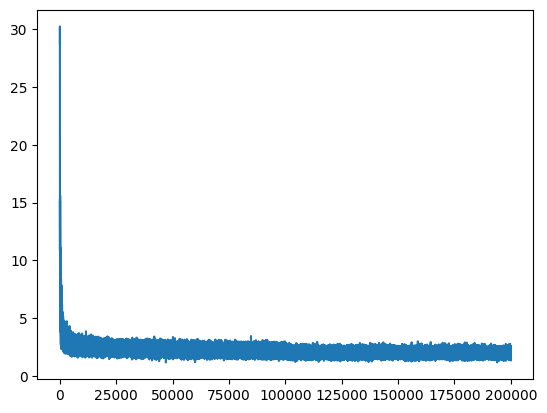

In [32]:
plt.plot(stepi, lossi)

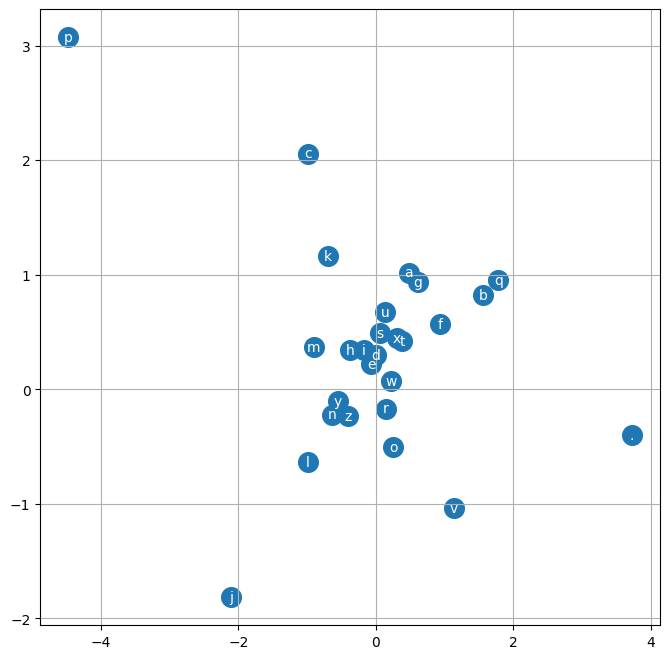

In [33]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [34]:
logits.max(1)

torch.return_types.max(
values=tensor([5.4370, 8.8789, 5.6044,  ..., 7.8621, 3.6014, 5.2113],
       grad_fn=<MaxBackward0>),
indices=tensor([ 1,  1, 18,  ..., 12, 14, 14]))

In [35]:
block_size = 3
context = [0] * block_size
C[torch.tensor([context])].shape

torch.Size([1, 3, 10])

In [36]:

# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))
    

carmah.
amerleel.
kemyriquety.
skanna.
eja.
hutlanderric.
kaeli.
nermaritzieigh.
kaleigh.
ham.
joce.
quinn.
salin.
alianni.
watell.
dearixi.
jaxselinsley.
dae.
iil.
gian.


In [ ]:
logits = torch.tensor([-5, -3, 0, 5])
counts = logits.exp()
prob = counts / counts.sum()
prob

In [ ]:
logits = torch.tensor([-100, -3, 0, 100])
counts = logits.exp()
prob = counts / counts.sum()
prob # inefficient for value of 100 we get inf prob

In [ ]:
logits = torch.tensor([-5, -3, 0, 100]) - 100
counts = logits.exp()
prob = counts / counts.sum()
prob # in cross entropy

In [ ]:
# we cannot simply do the above because diff sizes
# 32 3 2 ---> 32 6 then x 6 100(layer)
torch.concat([emd[:, 0, :], emd[:, 1, :], emd[:, 2, :]], 1).shape # not dynamic

In [ ]:
# unbaid to make it dynamic it breaks it into tuples as above given tensors
torch.concat(torch.unbind(emd, 1), 1)

In [ ]:
# Into internals of torch 
a = torch.arange(18)
a

In [ ]:
a.view(3, 2, 3) # all the numbers are always saved as onedimenional vector.

# Internal attributes of the tensor will be manipulated the storage remains same.

In [ ]:
emd.view(32, 6) == torch.cat(torch.unbind(emd, 1), 1)